## 04- Explicabilidad y Despliegue de la Solución

En este notebook evaluaremos una parte importante del desarrollo de herramientas analíticas como lo es la explicabilidad de los modelos. Para ejemplificar el uso de este tipo de enfoques, se utilizará uno de los mejores modelos hallado en el notebook anterior. A su vez, introduciremos el procedimiento para desplegarlo a través de un docker container.

In [27]:
## cargar uno de los mejores modelos

from model_parameters import *
import pickle
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(display='diagram')

with open("models/logistic_nopca.pickle", 'rb') as f:
    model = pickle.load(f)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cleaner',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['n_prod_prev',
                                                                          'total_siniestros',
                                                                          'total_pagado_smmlv',
                                                                          'anios_ultimo_siniestro',
                                                                          'Activos__c',
                                                                          'AnnualRevenue',
                                                                          'MontoAnual__c',
                                                                          'Otros...
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['tipo_prod_desc',
                                                                          'EstadoCivil__pc',
                                                                          'Genero__pc',
                                                                          'ciudad_name'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=4000,
                                                           solver='saga'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'model__l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'model__penalty': ['elasticnet']},
             scoring=make_scorer(cohen_kappa_score), verbose=True)

### Dificultad de usar el pipeline construido previamente

Debido a problemas de compatibilidad de módulos de entrenamiento, no todas las alternativas de explicabilidad de modelos analíticos son compatibles con pipelines de scikit learn. Sin embargo, podemos encontrar explicabilidad, al hacer el paso a paso del mejor modelo encontrado.

In [28]:
## Generar el modelo con los mejores parámetros obtenidos en el notebook anterior
# cargar data de test

train=pd.read_csv("train.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns='Asegurado__c')
test=pd.read_csv("test.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str}).drop(columns='Asegurado__c')

num_cols=[i for i in train.columns.values.tolist() if train[i].dtype!="O" and i not in ['churn','Profesion__pc','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','Tipo_poliza_c','tipo_ramo_name']]
str_cols=[i for i in train.columns.values.tolist() if train[i].dtype not in ["int32","float","int64"] and i not in ['churn','NumeroPoliza__c','Producto__c','Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','RamoTecnico__c','tipo_ramo_name','Tipo_poliza_c']]

scl=Pipeline([('imputer',SimpleImputer(fill_value=0,strategy="constant")),
        ('scaler',StandardScaler())])
        
cat_processor=OneHotEncoder(handle_unknown="ignore",sparse=False)
model=LogisticRegression(class_weight='balanced', l1_ratio=0.3, max_iter=4000,
                      penalty='elasticnet', solver='saga')
# model.best_estimator_.get_params()

In [30]:
##concatenar data y entrenar el modelo
cat_data=cat_processor.fit_transform(train[str_cols ])
data_num=pd.DataFrame(scl.fit_transform(train[num_cols]),columns=num_cols)
data_cat=pd.DataFrame(cat_data,columns=cat_processor.get_feature_names_out())
data=pd.concat((data_num,data_cat),axis=1)

## Entrenar Modelo con los mejores parámetros obtenidos

model.fit(data,train['churn'].values)

## Shap Values

A partir de los shap values es posible obtener una explicación del resultado del modelo. Sin embargo en pipelines con multiples transformaciones de datos, como la usada para el modelo de churn, limita la posibilidad de obtener mejores explicaciones

In [34]:
import shap

data_exp=data

In [35]:
explainer = shap.Explainer(model,data_exp)
shap_values = explainer(data_exp)

### Obtener explicación de la predicción de un individuo

Al analizar los valores Shap es posible establecer qué factores son relevantes al momento de hacer el cálculo de la probabilidad de churn. Para este caso, vemos cómo para un individuo seleccionado, el factor que más explica su probablidad de churn es el valor total recibido como pago en siniestros en SMMLV, el cual incrementa su riesgo de no renovación. A su vez, vemos que el total de siniestros y total de productos previos a la generación de la póliza, disminuyen la probabilidad de churn. Estos valores SHAP son una de las alternativas para la explicación de los modelos o técnicas de aprendizaje supervisado más novedosas y de mayor uso en la industria. 

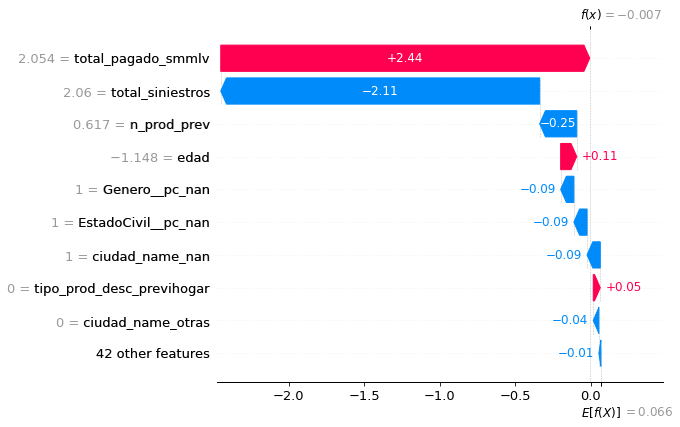

In [36]:
idx = 1
shap.plots.waterfall(shap_values[idx])

### Explicabilidad del efecto de los factores en el modelo

Mediante algunos elementos gráficos es posible ver el efecto positivo o negativo de cada factor o variable en el cálculo de la probabilidad de churn. El beeswarm plot permite ver en forma descendente la importancia de los factores, usando el valor SHAP promedio. Este gráfico representa todas las instancias de una variable y su color se define dependiendo del impacto en la estimación de la probabilidad de churn del modelo entrenado. Como podemos observar, el valor total pagado a un cliente por concepto de siniestros en SMMLV, el total de siniestros y productos previos, se consolidan como los factores de mayor relevancia, en la explicación del comportamiento del churn.

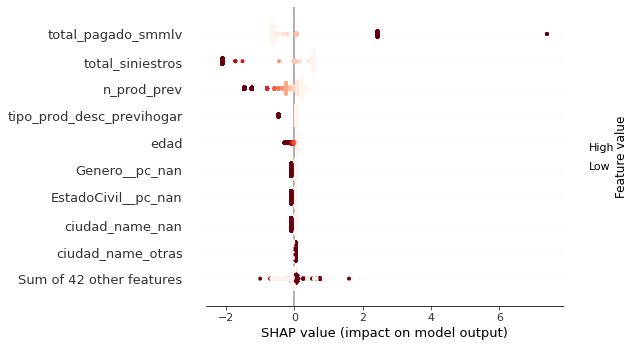

In [37]:
import matplotlib.pyplot as plt
shap.plots.beeswarm(shap_values, color=plt.get_cmap("Reds"))

Existen otros gráficos que son útiles al momento de representar la importancia de las variables en un modelo de analítica avanzada. Producto de los SHAP Values es posible obtener el aporte promedio por variable o feature, como se muestra a continuación.

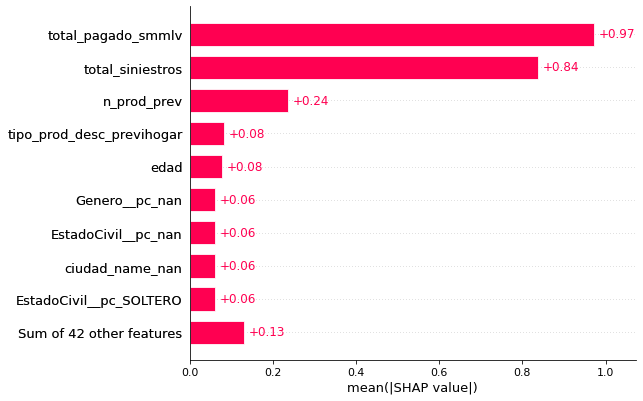

In [38]:
shap.plots.bar(shap_values.abs.mean(0))


## Despliegue de la solución

Una de las formas más comunes de disponibilizar las soluciones de analítica avanzada es a través de un servicio web. Con FastAPI este proceso se facilita. Una posible app del servicio de detección de churn se puede ver en la carpeta `app/` y el archivo Dockerfile que se muestra a continuación. 

En la etiqueta FROM usamos una imagen base para instalar nuestros requerimientos para correr una aplicación, previamente generada a través de FastAPI (Ver `app/app.py`). Con los comandos COPY Y RUN ejecutamos instrucciones de copia de datos necesarios e instrucciones en consola para la imagen Docker. Al final, mediante los comandos CMD le damos la instrucción de qué se debe ejecutar al iniciar la imagen docker. Para detalles sobre el funcionamiento de [FastAPI](https://fastapi.tiangolo.com/) y [Docker](https://docs.docker.com/), revisar la documentación disponible. 

```docker
FROM python:3.8-buster

# set working directory

WORKDIR /app
RUN mkdir -p /app

# install system dependencies

ENV DEBIAN_FRONTEND noninteractive
ENV DEBCONF_NONINTERACTIVE_SEEN true

RUN echo "tzdata tzdata/Areas select America" > /tmp/preseed.txt; \
    echo "tzdata tzdata/Zones/Europe select Bogota" >> /tmp/preseed.txt; \
    debconf-set-selections /tmp/preseed.txt && \
    apt-get update && \
    apt-get install -y tzdata


RUN apt-get update -y && apt-get install -y libgl1-mesa-glx \
	&& apt-get install -y libsm6 libxext6 && apt-get install -y git

# install dependencies

# copy content
ADD ./app /app
ADD ./models ../models
COPY ./requirements.txt .
#install python dependencies
RUN pip install --no-cache-dir --upgrade pip && pip install --no-cache-dir -r requirements.txt

#expose ports
EXPOSE 8001 5005 8005

CMD ["gunicorn","-c","gunicorn.py","-k","uvicorn.workers.UvicornWorker", "app:app"]

```